In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.base import clone
import shlex
import csv
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import gensim
from gensim.models import KeyedVectors
from gensim import models
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
from wordcloud import WordCloud

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
manual_input=["say","worker","company","said"]
stop_words=stop_words+manual_input

# Creating dataframe

In [ ]:
%%time
r = requests.get('https://qa.osapiens.cloud/data/integration/supplier-os-hub/supplier-os-hub/ExternalNewsExport/?type=LABELED&limit=100000&username=golchha.pujit@gmail.com&password=Golchha@1999')

CPU times: user 609 ms, sys: 142 ms, total: 750 ms
Wall time: 1min 53s


In [ ]:
r.text

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
header=r.text.split("\r\n")[0].split(",")
header

['id', 'ts', 'source', 'title', 'content', 'confirmedLabel']

In [ ]:
raw_string=r.text.replace('\r\n"','"')
raw_string=re.sub(r'id,ts,source,title,content,confirmedLabel\r\n','',r.text)
raw_string=re.sub(r'([^\d])(\r\n)+', r'\1',raw_string)


In [ ]:
raw_string

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data=[]
for rowno,i in enumerate(tqdm(raw_string.split("\r\n"))):
  text=''
  a=[]
  #z is indicator variable if the string contains ""
  z=False
  for j in i.split(","):
    #some columns may be empty
    if j!="":
      #accounting for ""
      #we continue concatenating all parts to the text until we encounter another"
      if j[0]=='"' or z==True:
        text=text+j
        z=True
      else:
        a.append(j)
      try:
        if j[-1]=='"' and j[-2]!='"':
          a.append(text)
          text=''
          z=False
      except:
         if j[-1]=='"':
          a.append(text)
          print(rowno)
          print(text)
          text=''
          z=False
    else:
      a.append("")


  data.append(a)

 35%|███▍      | 18314/53034 [00:00<00:00, 183122.71it/s]

72
"Jennifer Nichols meets an apiarist who has mastered the skill of rescuing bees from inside homes and buildings"
2658
"A new FBI report show a 50% jump in active-shooter incidents from 2020 to 2021"
10529
"President Joe Biden has tested positive for Covid-19 and is experiencing ""mild symptoms"" White House press secretary Karine Jean-Pierre said Thursday."
12283
"The reasons of those who identify Pujol as the cause and origin of the Catalan decline are powerful both for his responsibilities regarding the independence process and corruption"
14531
"Leclerc wins by a landslide and Sainz gets burned in the Austrian Grand Prix"
27951
"The 75th edition of the prestigious Cannes Film Festival witnesses the return of international auteurs Palme d'Or winning filmmakers potential summer blockbusters and many films that will"
28117
"Rohit who was playing in India's ongoing four-day warm-up game against Leicestershire ahead of the rescheduled fifth Test against England has gone into quarantin

100%|██████████| 53034/53034 [00:00<00:00, 162386.11it/s]

40184
"The announcement came in response to a class action lawsuit that previously included student loan borrowers from at least 100 different colleges"
40473
"President Vladimir Putin spent 628 billion rubles on his military in April Russia's Ministry of Finance reported"
41589
"Fire officials said that 10 homes had been destroyed in south Taylor County as the Mesquite Heat fire burned for a second day"
41622
"Since President Biden made a public commitment in March to welcome 100000 Ukrainian refugees the U.S. has only admitted about 27000"
43927
"The NBA one of the most popular U.S. cultural exports in China has lost ""hundreds of millions"" of dollars because of the blackout commissioner Adam Silver said"
44606
"Donny Ubiera allegedly stabbed two men without provocation in separate incidents in Queens on Friday and Saturday morning along the Flushing-to-Midtown subway line NYPD said"


In [ ]:
data=pd.DataFrame(data, columns=header)

In [ ]:
data.drop(len(data)-1,axis=0,inplace=True)

In [ ]:
data=data[~((data["title"].isna()) & (data["content"].isna()))]
data=data[~data["confirmedLabel"].isna()]

In [ ]:
data

,id,ts,source,title,content,confirmedLabel
0,abc.es-1c3ef10282721375df4426f954bf89cd8d96f57f,1664446706000,abc.es,"""Mauricio Claver-Carone former IDB President:...","""Latin America's largest investment bank is in...",1
1,abc.es-4a46a95515b98ed21283ad164130c3139981b753,1664211794000,abc.es,León's garbage workers postpone their strike,"""The workers of the garbage collection service...",0
2,abc.es-9067af483ba8f35028c6106b9af3e6162eb4bdaf,1664447054000,abc.es,The firefighters of the Bejís fire have not ye...,"""The Central Independent Trade Union and Civil...",2
3,abc.es-9f18b7b37e3d1b287eafb09ace126d32629fa90a,1664448828000,abc.es,Leakage from Nord Stream is equivalent to the ...,""" The smoking pool of methane gas in the Balti...",1
4,abc.es-ad273960697997f76f5a4aaca52721d16cb2ab80,1664441927000,abc.es,"""Labour expels MP for saying UK Chancellor of ...","""The English MP Rupa Huq has been expelled as ...",1
...,...,...,...,...,...,...
53028,yahoo.com-fef60f9345dd2dbf9f120bf40d27e48edf72...,1654034016000,yahoo.com,Amber Heard's lawyers told jurors a verdict ag...,,0
53029,yahoo.com-ff86305c30e24585534e1064dd52483aed71...,1653150583000,yahoo.com,A Maine town reportedly shut down after its on...,,0
53030,yahoo.com-ffb99a82ff176686aa6cd70b5de3134418c0...,1652871195000,yahoo.com,"""High-profile candidates endorsed by Trump los...",,0
53031,yahoo.com-ffcc76f8ebce23fee39d5df0965ec86924b6...,1653477680000,yahoo.com,China Protesters Demand Back Billions Invested...,,0


In [ ]:
training_data=pd.read_csv("/content/drive/MyDrive/Chain_News_Monitoring_Project/Pujit/training_data.csv")
training_data

,Unnamed: 0,id,ts,source,title,content,confirmedLabel
0,0,abc.es-1c3ef10282721375df4426f954bf89cd8d96f57f,1664446706000,abc.es,"""Mauricio Claver-Carone former IDB President:...","""Latin America's largest investment bank is in...",1
1,1,abc.es-9067af483ba8f35028c6106b9af3e6162eb4bdaf,1664447054000,abc.es,The firefighters of the Bejís fire have not ye...,"""The Central Independent Trade Union and Civil...",2
2,2,abc.es-9f18b7b37e3d1b287eafb09ace126d32629fa90a,1664448828000,abc.es,Leakage from Nord Stream is equivalent to the ...,""" The smoking pool of methane gas in the Balti...",1
3,3,abc.es-ad273960697997f76f5a4aaca52721d16cb2ab80,1664441927000,abc.es,"""Labour expels MP for saying UK Chancellor of ...","""The English MP Rupa Huq has been expelled as ...",1
4,4,abc.net.au-004a920f2038bba4473cfb627730f2fac36...,1656022155000,abc.net.au,"""'It's our history it's our everything': Farme...",Landowners says there was no consultation over...,0
...,...,...,...,...,...,...,...
51325,52305,yahoo.com-fef60f9345dd2dbf9f120bf40d27e48edf72...,1654034016000,yahoo.com,Amber Heard's lawyers told jurors a verdict ag...,NaN,0
51326,52306,yahoo.com-ff86305c30e24585534e1064dd52483aed71...,1653150583000,yahoo.com,A Maine town reportedly shut down after its on...,NaN,0
51327,52307,yahoo.com-ffb99a82ff176686aa6cd70b5de3134418c0...,1652871195000,yahoo.com,"""High-profile candidates endorsed by Trump los...",NaN,0
51328,52308,yahoo.com-ffcc76f8ebce23fee39d5df0965ec86924b6...,1653477680000,yahoo.com,China Protesters Demand Back Billions Invested...,NaN,0


In [ ]:
data.loc[data["confirmedLabel"]=="1"]

,id,ts,source,title,content,confirmedLabel
0,abc.es-1c3ef10282721375df4426f954bf89cd8d96f57f,1664446706000,abc.es,"""Mauricio Claver-Carone former IDB President:...","""Latin America's largest investment bank is in...",1
3,abc.es-9f18b7b37e3d1b287eafb09ace126d32629fa90a,1664448828000,abc.es,Leakage from Nord Stream is equivalent to the ...,""" The smoking pool of methane gas in the Balti...",1
4,abc.es-ad273960697997f76f5a4aaca52721d16cb2ab80,1664441927000,abc.es,"""Labour expels MP for saying UK Chancellor of ...","""The English MP Rupa Huq has been expelled as ...",1
2389,abcnews.com-8805f5c4afe940493631a55878671426f9...,1653620154000,abcnews.com,""" President: 11 babies killed in fire at Seneg...",Senegal's president says 11 newborns have died...,1
2446,abcnews.com-8c150ba55c4d0701fedd3e9ecea95435b0...,1659721729000,abcnews.com,""" Efforts continue to reach 10 miners northern...","""Round-the-clock pumping slightly lowered the ...",1
...,...,...,...,...,...,...
51186,theguardian.com-df1f59377839e7ba39d912f88e6d7a...,1657823933000,theguardian.com,The smell of indequate regulation around Engla...,"""The Environment Agency has tough words for po...",1
51221,theguardian.com-e4804937f4b30cefad13a367d70964...,1654778611000,theguardian.com,Fury as Wizz Air boss suggests too many pilots...,"""Pilots’ union urges aviation regulator to act...",1
51284,theguardian.com-eedb627c11360d4cc3bd67558b6b5e...,1653652802000,theguardian.com,National Farmers Union funding legal challenge...,"""Exclusive: Environmental groups criticise NFU...",1
51599,un.org-8dd31f760940a8048a6e069347785fe10008eb80,1654531924000,un.org,Bangladesh: ILO calls for workplace safety rev...,"""A fire and explosion in southeastern Banglade...",1


# EDA

In [ ]:
corpus=list(data.loc[data["confirmedLabel"]=="2"]["content"])

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

print(len(vectorizer.get_feature_names_out()))


3880


In [ ]:
X.toarray().sum(axis = 0)

array([ 2,  1, 13, ...,  1,  2,  1])

In [ ]:
word_counts=pd.DataFrame({"Words":vectorizer.get_feature_names_out(),"Count":X.toarray().sum(axis = 0)})
word_counts.sort_values("Count",ascending=False)

,Words,Count
3465,the,777
1729,in,476
2386,of,454
3515,to,344
277,and,341
...,...,...
2229,mobilization,1
2230,moderate,1
2231,moderator,1
2232,moderators,1


In [ ]:
def regex_filter(val):
    if val:
        mo = re.search("\d+",val)
        if mo:
            return False
        else:
            return True
    else:
        return False

In [ ]:
word_counts=word_counts.loc[~word_counts["Words"].isin(list(stop_words))][word_counts["Words"].apply(regex_filter)].sort_values("Count",ascending=False)
word_counts.sort_values("Count",ascending=False,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
b=[]
for cat,number in zip(word_counts["Words"][0:100],word_counts["Count"][0:100]):
   a=[cat]*number
   b=b+a

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(cat for cat in b))

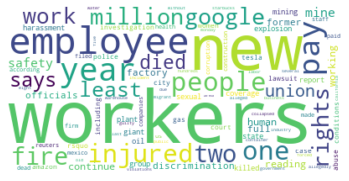

In [ ]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df=pd.DataFrame(data.groupby(["source"])["confirmedLabel"].value_counts()).rename(columns={"confirmedLabel":"Count"}).reset_index()

In [ ]:
df=df.pivot("source", "confirmedLabel", values="Count").fillna(0)

In [ ]:
df["proportion"]=df["2"]/(df["2"]+df["0"]+df["1"])*100

In [ ]:
df

confirmedLabel,0,1,2,proportion
source,,,,
abc.es,0.0,3.0,1.0,25.000000
abc.net.au,666.0,0.0,19.0,2.773723
abcnews.com,2940.0,5.0,77.0,2.547981
aljazeera.com,1047.0,3.0,31.0,2.867715
bbci.co.uk,3891.0,3.0,65.0,1.641829
business-humanrights.org,478.0,2.0,267.0,35.742972
businessnews.co.id,2.0,1.0,0.0,0.000000
buzzfeed.com,96.0,0.0,3.0,3.030303
chicagotribune.com,345.0,0.0,4.0,1.146132


In [ ]:
import circlify
df=df.loc[df['proportion']!=0].sort_values("proportion",ascending=True)
# compute circle positions:
circles = circlify.circlify(
   df['proportion'].tolist(), 
    show_enclosure=False
)

In [ ]:
df

confirmedLabel,0,1,2,proportion
source,,,,
newsweek.com,1879.0,0.0,3.0,0.159405
politico.com,447.0,0.0,1.0,0.223214
lefigaro.fr,4783.0,5.0,16.0,0.333056
nypost.com,2337.0,1.0,10.0,0.425894
google.com,6250.0,1.0,29.0,0.461783
indiatimes.com,9911.0,8.0,50.0,0.501555
yahoo.com,1174.0,1.0,6.0,0.508044
spiegel.de,2471.0,3.0,13.0,0.522718
un.org,375.0,1.0,2.0,0.529101


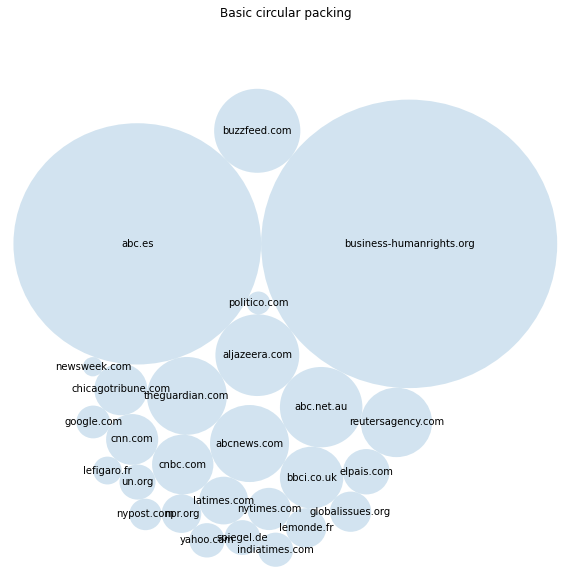

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

# Title
ax.set_title('Basic circular packing')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = df.index

# print circles
for circle, label in zip(circles, labels):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2))
    plt.annotate(
          label, 
          (x,y ) ,
          va='center',
          ha='center'
     )

# Embedding creation

In [ ]:
def preprocessing(document):
    # Remove punctuation and numbers
    try:
        
      document = re.sub(r"[^A-Za-z\u00c0-\u017e\s]+", " ", document)

      # Remove extra white spaces
      doc= re.sub(r"[\s]{2,}", " ", document)
      

      doc = word_tokenize(doc)
      doc = [word for word in doc if word not in stop_words]
    except:
      doc=[]
    return doc

In [ ]:
corpus = [preprocessing(title) for title in tqdm(list(data["content"]))]

In [ ]:
corpus_title = [preprocessing(title) for title in tqdm(list(data["title"]))]

100%|██████████| 51330/51330 [00:09<00:00, 5561.21it/s]


In [ ]:
corpus_flat=[]
for i in tqdm(corpus):
  corpus_flat=corpus_flat+i


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_flat)
vocab=vectorizer.get_feature_names_out()

print(len(vectorizer.get_feature_names_out()))

70139


In [ ]:
print(X[1])

  (0, 1910)	1


In [ ]:
vocab

array(['aa', 'aaa', 'aaccord', ..., 'zycryptoview', 'zydus',
       'zyverodonetsk'], dtype=object)

In [ ]:
w2v_model = models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Chain_News_Monitoring_Project/Pujit/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
words_filtered = [word for word in vocab if word in w2v_model.key_to_index]
vec_filtered = {word:w2v_model[word] for word in vocab if word in w2v_model.key_to_index}

In [ ]:
len(words_filtered)

36872

In [ ]:
def document_vector(doc):
    # remove out-of-vocabulary words
      doc = [word for word in doc if word in w2v_model.key_to_index]
      return np.mean(w2v_model[doc], axis=0)


In [ ]:
from nltk.translate.gale_church import parse_token_stream
finaldf=[]
for i,j,k,l in tqdm(zip(corpus,data["id"],data["confirmedLabel"],corpus_title)):
  try:
    doc_Embedding=document_vector(i)
    finaldf.append({"id":j,"label":k,"emebedding":doc_Embedding})
  except:
    try:
      doc_Embedding=document_vector(l)
      finaldf.append({"id":j,"label":k,"emebedding":doc_Embedding})
    except:
      pass


51330it [00:05, 9648.31it/s]


In [ ]:
finaldf=pd.DataFrame(finaldf)

In [ ]:
finaldf[list(range(0, 300))] = pd.DataFrame(finaldf.emebedding.tolist(), index= finaldf.index)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [ ]:
finaldf.drop(columns='emebedding', inplace= True)
finaldf['label'] = finaldf['label'].astype(int)
finaldf = finaldf[finaldf['label']!=1]
finaldf['label'] = finaldf['label'].replace(2,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
finaldf.to_csv("/content/drive/MyDrive/Chain_News_Monitoring_Project/Pujit/w_2_vec.csv",index=False)

In [ ]:
finaldf["label"].value_counts()

0    50533
1      732
Name: label, dtype: int64

# Experimentation

In [ ]:
class MetaCost(object):

    """A procedure for making error-based classifiers cost-sensitive
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.linear_model import LogisticRegression
    >>> import pandas as pd
    >>> import numpy as np
    >>> S = pd.DataFrame(load_iris().data)
    >>> S['target'] = load_iris().target
    >>> LR = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    >>> C = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
    >>> model = MetaCost(S, LR, C).fit('target', 3)
    >>> model.predict_proba(load_iris().data[[2]])
    >>> model.score(S[[0, 1, 2, 3]].values, S['target'])
    .. note:: The form of the cost matrix C must be as follows:
    +---------------+----------+----------+----------+
    |  actual class |          |          |          |
    +               |          |          |          |
    |   +           | y(x)=j_1 | y(x)=j_2 | y(x)=j_3 |
    |       +       |          |          |          |
    |           +   |          |          |          |
    |predicted class|          |          |          |
    +---------------+----------+----------+----------+
    |   h(x)=j_1    |    0     |    a     |     b    |
    |   h(x)=j_2    |    c     |    0     |     d    |
    |   h(x)=j_3    |    e     |    f     |     0    |
    +---------------+----------+----------+----------+
    | C = np.array([[0, a, b],[c, 0 , d],[e, f, 0]]) |
    +------------------------------------------------+
    """
    def __init__(self, S, L, C, m=50, n=1, p=True, q=True):
        """
        :param S: The training set
        :param L: A classification learning algorithm
        :param C: A cost matrix
        :param q: Is True iff all resamples are to be used  for each examples
        :param m: The number of resamples to generate
        :param n: The number of examples in each resample
        :param p: Is True iff L produces class probabilities
        """
        if not isinstance(S, pd.DataFrame):
            raise ValueError('S must be a DataFrame object')
        new_index = list(range(len(S)))
        S.index = new_index
        self.S = S
        self.L = L
        self.C = C
        self.m = m
        self.n = len(S) * n
        self.p = p
        self.q = q

    def fit(self, flag, num_class):
        """
        :param flag: The name of classification labels
        :param num_class: The number of classes
        :return: Classifier
        """
        col = [col for col in self.S.columns if col != flag]
        S_ = {}
        M = []

        for i in tqdm(range(self.m)):
            # Let S_[i] be a resample of S with self.n examples
            S_[i] = self.S.sample(n=self.n, replace=True)

            X = S_[i][col].values
            y = S_[i][flag].values

            # Let M[i] = model produced by applying L to S_[i]
            model = clone(self.L)
            M.append(model.fit(X, y))

        label = []
        S_array = self.S[col].values
        for i in tqdm(range(len(self.S))):
            if not self.q:
                k_th = [k for k, v in S_.items() if i not in v.index]
                M_ = list(np.array(M)[k_th])
            else:
                M_ = M

            if self.p:
                P_j = [model.predict_proba(S_array[[i]]) for model in M_]
            else:
                P_j = []
                vector = [0] * num_class
                for model in M_:
                    vector[model.predict(S_array[[i]])] = 1
                    P_j.append(vector)

            # Calculate P(j|x)
            P = np.array(np.mean(P_j, 0)).T

            # Relabel
            label.append(np.argmin(self.C.dot(P)))

        # Model produced by applying L to S with relabeled y
        X_train = self.S[col].values
        y_train = np.array(label)
        model_new = clone(self.L)
        model_new.fit(X_train, y_train)

        return model_new

In [ ]:
finaldf = pd.read_csv('/content/drive/MyDrive/Chain_News_Monitoring_Project/Pujit/w_2_vec.csv')

In [ ]:
pca = PCA(n_components=15, random_state=10)
finaldf[list(range(300, 315))] = pca.fit_transform(finaldf.drop(columns=['id','label']))

In [ ]:
finaldf

,id,label,0,1,2,3,4,5,6,7,...,305,306,307,308,309,310,311,312,313,314
0,abc.es-9067af483ba8f35028c6106b9af3e6162eb4bdaf,1,0.006668,0.016495,0.023311,0.039545,-0.004960,-0.050312,0.053953,-0.071999,...,-0.052765,-0.033292,-0.216160,-0.042462,-0.013576,0.007102,0.012177,0.038472,0.041918,-0.071258
1,abc.net.au-004a920f2038bba4473cfb627730f2fac36...,0,0.021872,0.020473,0.053035,0.010879,-0.068738,-0.028451,-0.003396,-0.029626,...,-0.135794,-0.089686,-0.220264,0.008203,-0.167471,0.085970,-0.032393,-0.065692,0.032643,0.048091
2,abc.net.au-008d10e9fcbb6f5e98ffe13c0be9f617e0f...,0,-0.012427,-0.015906,-0.017944,0.039648,-0.041689,-0.010559,0.013008,-0.084271,...,0.114555,0.193751,0.034137,0.148548,0.043069,0.090685,-0.173937,-0.063909,0.034881,0.099706
3,abc.net.au-01179d26eb5a23507f0b67e416733541e48...,0,-0.002159,0.020969,-0.044596,0.094140,-0.121067,-0.026611,0.010037,-0.095228,...,0.107828,-0.114513,-0.061701,-0.096536,-0.069452,0.150701,0.047174,-0.056875,0.003300,0.225883
4,abc.net.au-01751a628e450217db4e6f3820ca2bce421...,0,-0.029331,0.137109,-0.071021,0.017089,0.066170,-0.012869,-0.097078,-0.043848,...,0.115603,-0.043124,-0.050566,-0.170476,0.130620,0.283722,0.031996,-0.066133,-0.059946,0.077425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51260,yahoo.com-fef60f9345dd2dbf9f120bf40d27e48edf72...,0,0.010216,0.042625,-0.025818,0.096582,-0.019791,0.030582,0.008952,-0.055915,...,-0.106417,0.117585,0.156807,0.001259,-0.098107,0.085139,0.106192,0.019794,-0.097483,0.082817
51261,yahoo.com-ff86305c30e24585534e1064dd52483aed71...,0,0.046542,0.031512,-0.045850,-0.056199,-0.053662,0.006256,-0.043317,-0.106677,...,-0.205770,-0.181806,0.071315,-0.047994,-0.175643,0.006232,0.021075,0.073140,0.044390,-0.043334
51262,yahoo.com-ffb99a82ff176686aa6cd70b5de3134418c0...,0,-0.004955,0.053550,0.022583,0.010398,-0.057229,-0.117953,-0.056585,-0.063278,...,-0.134936,-0.062487,0.089161,-0.210529,-0.055851,0.069946,-0.076041,-0.082917,-0.015014,0.229650
51263,yahoo.com-ffcc76f8ebce23fee39d5df0965ec86924b6...,0,0.102585,0.136200,-0.056396,0.112875,-0.090996,0.069321,-0.150513,-0.057388,...,-0.304306,0.343999,0.248895,-0.178766,-0.042429,0.318382,-0.423408,0.347823,0.230035,-0.144069


In [ ]:
finaldf_pca=finaldf.drop(columns=[str(x) for x in range(0,300)])

In [ ]:
X_train, X_test = train_test_split(finaldf_pca.drop(columns='id'), test_size = 0.2, random_state = 10)

In [ ]:
X_train, X_test = train_test_split(finaldf.drop(columns='id'), test_size = 0.2, random_state = 10)

In [ ]:
X_train

,label,0,1,2,3,4,5,6,7,8,...,305,306,307,308,309,310,311,312,313,314
50843,0,-0.017415,0.094279,-0.056247,0.148112,-0.022834,-0.050008,0.073649,-0.146267,0.161411,...,-0.127378,-0.309054,0.186374,-0.078049,0.199453,0.102262,0.027791,0.038932,-0.074273,-0.003240
41271,0,0.010839,0.077342,-0.012986,-0.006275,-0.032078,-0.001644,0.074305,-0.114872,0.099839,...,0.010900,0.052086,0.104492,0.058935,0.184222,-0.052612,0.108090,-0.022274,0.114012,-0.027397
20210,0,-0.008863,0.037109,0.017634,0.023794,-0.055015,-0.064900,0.021317,-0.122303,0.074496,...,-0.086921,-0.122501,-0.005138,0.172555,0.104757,-0.041034,0.026159,0.003205,0.030274,0.044262
47497,0,-0.052311,0.061801,0.086353,-0.003523,-0.114733,-0.076414,0.028801,-0.075423,0.059438,...,0.091576,-0.040397,-0.001249,0.102978,-0.121273,-0.090164,0.007076,-0.129763,0.220712,-0.023844
33405,0,0.070163,0.036954,0.029344,0.000205,0.011153,-0.066992,-0.002090,-0.083628,0.094682,...,0.005973,-0.121651,-0.049570,-0.107627,-0.049010,-0.098349,-0.080996,-0.138326,0.003897,-0.119513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28017,0,0.022202,0.097507,-0.000839,0.073580,-0.057430,-0.024015,-0.087883,-0.114183,0.114223,...,-0.134961,-0.195366,0.294540,-0.035738,0.093946,0.258355,-0.028172,-0.006565,-0.142443,-0.060913
50496,0,-0.031177,0.068034,0.074802,0.022999,0.003581,0.005642,0.020840,0.034061,0.164103,...,-0.006153,0.072892,0.230226,-0.174166,0.099983,0.036409,-0.171024,0.067671,0.258481,-0.277744
29199,0,0.029817,0.074925,0.127362,-0.027696,-0.024845,-0.038155,0.029697,-0.063578,0.053626,...,-0.139144,-0.094362,0.113193,-0.018497,0.120786,-0.035031,0.007313,-0.082889,0.127817,-0.011564
40061,0,0.041935,0.009277,-0.054077,0.149691,-0.070386,0.000767,0.070982,-0.046582,0.090973,...,-0.005555,0.104596,0.137538,-0.089616,-0.051117,-0.039900,0.090500,0.185331,0.034680,-0.068595


In [ ]:
xgc = xgb.XGBClassifier(random_state=10)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [ ]:
r =70
C = np.array([[0, 1000*r], [1000, 0]])
model = MetaCost(X_train,xgc, C, m=50, n=1).fit('label', 2)
# model.predict_proba()
# model.score(S[[0, 1, 2, 3]].values, S['target'])

100%|██████████| 41012/41012 [00:41<00:00, 984.89it/s]


In [ ]:
z=model.predict( X_test.drop(columns="label").values)
model.score(X_test.drop(columns="label").values, X_test['label'])

0.96644884424071

In [ ]:

confusion_matrix(X_test['label'],z,labels=[0,1])

array([[9852,  238],
       [ 106,   57]])

In [ ]:
#with pca
# r=20
# 0.96644884424071
# array([[9852,  238],
#        [ 106,   57]])


# r=5
# 0.98
# array([[10075,  15],
#        [ 146,   17]])


# without meta cost
#0.9841022139861504
# array([[10090,     0],
#        [  163,     0]])


In [ ]:

logreg.fit(X_train.drop(columns="label"),X_train["label"])

LogisticRegression()

In [ ]:
model = xgb.XGBClassifier(random_state=10)
model.fit(X_train.drop(columns="label"),X_train["label"])
z=model.predict( X_test.drop(columns="label"))
model.score(X_test.drop(columns="label"), X_test['label'])
confusion_matrix(X_test['label'],z,labels=[0,1])

array([[10090,     0],
       [  163,     0]])

In [ ]:
model.score(X_test.drop(columns="label"), X_test['label'])

0.9841022139861504